# U-Net segmentation example
### Advanced Deep Learning 2024
This notebook was originally written by Mathias Perslev. It has been changed slightly by Christian Igel and subsequently slightly updated Stefan Sommer (mailto:sommer@di.ku.dk) and Jon Sporring (mailto:sporring@di.ku.dk).

We consider the data described in:

Bram van Ginneken, Mikkel B. Stegmann, Marco Loog. [Segmentation of anatomical structures in chest radiographs using supervised methods: a comparative study on a public database](https://doi.org/10.1016/j.media.2005.02.002). *Medical Image Analysis* 10(1): 19-40, 2006


## Installs

On non-colab system, is usually good to make an environment and install necessary tools there. E.g., anaconda->jupyter->terminal create an environment, if you have not already, and activate it:
```
conda create -n adl python=3.9
conda activate adl
```
then install missing packages such as:
```
conda install ipykernel torch matplotlib torchmetrics scikit-image jpeg
conda install -c conda-forge segmentation-models-pytorch ipywidgets
```
and if you want to add it to jupyter's drop-down menu
```
ipython kernel install --user --name=adl
```
Now reload the jupyter-notebook's homepage and make a new or load an existing file. On colab, the tools have to be installed everytime

In [23]:
"""try:
  import google.colab
  IN_COLAB = True
except:
  IN_COLAB = False
if IN_COLAB:
    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch"""

'try:\n  import google.colab\n  IN_COLAB = True\nexcept:\n  IN_COLAB = False\nif IN_COLAB:\n    !pip3 install torch matplotlib torchmetrics scikit-image segmentation-models-pytorch'

## Imports

In [1]:
import torch
from torch import nn as nn
from torch.nn import functional as F
from torchvision.datasets.utils import download_url

from torch import Tensor

import torchmetrics

import segmentation_models_pytorch as smp

import os
import matplotlib.pyplot as plt
import numpy as np

from pprint import pformat
from skimage.transform import resize
from pathlib import Path
from glob import glob
from matplotlib.pyplot import imread
from collections import defaultdict

import wandb

## Set global device

In [2]:
# GPU support?
gpu = torch.cuda.is_available()
device = torch.device("cuda:0" if gpu else "cpu")
print("device:", device)

device: cpu


## Functions
### Loading data sets

In [3]:
def load_npz_dataset(path, keys=('x_train', 'y_train', 'x_val', 'y_val', 'x_test', 'y_test')):
    archive = np.load(path)
    return [archive.get(key) for key in keys]

def as_torch_dataset(x_arr, y_arr):
    """
    Takes two numpy arrays of data points and labels (x_arr and y_arr, respectively) and
    returns a torch TensorDataset object.

    Returns: torch.utils.data.TensorDataset
    """
    dataset = torch.utils.data.TensorDataset(
        torch.FloatTensor(x_arr),
        torch.FloatTensor(y_arr)
    )
    return dataset

### Visualization

In [4]:
def plot_image_with_segmentation(image, segmentation, ax=None):
    """
    Plots an image with overlayed segmentation mask. Segmentation is thresholded at 0.5

    Returns: plt.fig and ax objects
    """
    if ax is None:
        fig = plt.figure(figsize=(8, 8))
        ax = fig.add_subplot(111)
        ax.axis("off")

    im = image.cpu().detach().numpy()
    segm = segmentation.cpu().detach().numpy()
    ax.imshow(im.squeeze(), cmap="gray")
    mask = segm < 0.5
    ax.imshow(mask.squeeze(), cmap="Set1", alpha=0.5)
    return plt.gcf(), ax

### Evaluating a model on data

In [5]:
def evaluate_model_on_single_image(model, x, device=device):
    """
    Evaluate a model on a single data point on the device.

    Returns: model(x)
    """
    with torch.no_grad():
        x = x.to(device)
        return model(x.view(1, *x.shape))

In [6]:
def evaluate_model(model, data_loader, metrics_dict, reduction=True, device=device):
    """
    Evaluate a model 'model' on all batches of a torch DataLoader 'data_loader'.
    On each batch, compute all metric functions stored in dictionary 'metrics_dict'.

    Returns: dict of metric_name: (list of batch-wise metrics if reduction == False, else single scalar)
    """

    # defaultdict(list) returns a dictionary-like object with default_factory list.
    # When a new key is encountered, an entry is automatically created of type default_factory.
    metrics = defaultdict(list)
    with torch.no_grad():
        for i, (batch_x, batch_y) in enumerate(data_loader):
            # Predict on batch
            batch_x = batch_x.to(device)
            batch_y = batch_y.to(device)
            logits = model(batch_x)

            # Compute all metrics
            for metric_name, metric_func in metrics_dict.items():
                value = metric_func(logits.cpu(), batch_y.cpu()).item() #.cpu().numpy()
                metrics[metric_name].append(value)

    if reduction == True:
        # Return mean values
        return {key: np.mean(value) for key, value in metrics.items()}
    else:
        return metrics


### Saving and loading model and optimizer state

In [7]:
def save_model(model, path, optimizer=None):
    """
    Saves the state_dict of a torch model and optional optimizer to 'path'
    Returns: None
    """
    state = {"model": model.state_dict()}
    if optimizer is not None:
        state["optimizer"] = optimizer.state_dict()
    torch.save(state, path)


def load_model(model, path, optimizer=None):
    """
    Loads the state_dict of a torch model and optional optimizer from 'path'
    Returns: None
    """
    state = torch.load(path)
    model.load_state_dict(state["model"])
    if optimizer is not None:
        optimizer.load_state_dict(state["optimizer"])

### Plotting training/validation histories

In [8]:
def plot_histories(train_history=None, val_history=None, label="Loss"):
    """
    Takes a list of training and/or validation metrics and plots them
    Returns: plt.figure and ax objects
    """
    if not train_history and not val_history:
        raise ValueError("Must specify at least one of 'train_histories' and 'val_histories'")
    fig = plt.figure(figsize=(5, 3))
    ax = fig.add_subplot(111)

    epochs = np.arange(len(train_history or val_history))
    if train_history:
        ax.plot(epochs, train_history, label="Training", color="black")
    if val_history:
        ax.plot(epochs, val_history, label="Validation", color="darkred")

    ax.set_xlabel("Epoch")
    ax.set_ylabel(label)
    ax.legend(loc=0)

    return fig, ax

### Main training loop

We want to track the F1 score during training. This generates some additional code.

In [9]:
def run_one_epoch(model, loss, optimizer, train_loader, val_loader, n_epochs, metrics_dict, device=device):
    """
    Run 1 epoch of training
    Changes to model parameters and optimizer occour internally (state updates)
    Returns:
        two dictionaries, training and a validation metrics
    """
    train_losses = []
    for i, (batch_x, batch_y) in enumerate(train_loader):
        # Zero out stored gradients for all parameters
        batch_x = batch_x.to(device)
        batch_y = batch_y.to(device)
        optimizer.zero_grad()

        print(f"   -- Batch {i+1}/{len(train_loader)}", end=" / ")
        # Predict on batch
        logits = model(batch_x)

        # Compute loss function
        loss_tensor = loss(logits, batch_y)
        loss_scalar = loss_tensor.detach().cpu().numpy()
        train_losses.append(loss_scalar)
        print("Loss: ", loss_scalar)

        # Backprop and step
        loss_tensor.backward()
        optimizer.step()

    # Run validation
    print("   Validation running...")
    val_metrics = evaluate_model(
        model=model,
        data_loader=val_loader,
        metrics_dict=metrics_dict
    )
    # Return loss and metrics as dicts
    return {"loss": np.mean(train_losses)}, val_metrics


def merge_list_of_dicts(list_of_dicts):
    """
    Takes a list of dictionaries and merges them into a single dictionary pointing to lists

    E.g. [{"loss": 5}, {"loss": 3}, {"loss": -2, "F1": 0.5}] --> {"loss": [5, 3, -2], "F1": [0.5]}

    Returns: dict
    """
    merged = defaultdict(list)
    for dict_ in list_of_dicts:
        for value, key in dict_.items():
            merged[value].append(key)
    return merged


def training_loop(model, loss, optimizer, train_loader, val_loader, n_epochs, init_epoch=None, metrics_dict=None, save_path=None):
    """
    Run training of a model given a loss function, optimizer and a set of training and validation data.
    Supports computing additional metrics on the validation set (only) via the metrics_dict param.
    Specify save_path to store the model at each epoch.

    Returns:
        Two lists of metric dictionaries for each epoch for training and validation, specifically
    """
    train_history, val_history = [], []

    metrics_with_loss = {"loss": loss}
    if metrics_dict is not None:
        metrics_with_loss.update(metrics_dict)

    if init_epoch == None:
        init_epoch = 0
    try:
        for i in range(init_epoch, n_epochs):
            print(f"Epoch {i+1}/{n_epochs}")
            train_metrics, val_metrics = run_one_epoch(
                model=model,
                loss=loss,
                optimizer=optimizer,
                train_loader=train_loader,
                val_loader=val_loader,
                n_epochs=n_epochs,
                metrics_dict=metrics_with_loss
            )
            print("   Mean epoch metrics:")
            print(f"   Training:   {pformat(train_metrics)}")
            print(f"   Validation: {pformat(val_metrics)}")
            train_history.append(train_metrics), val_history.append(val_metrics)
            print(f"Train metrics: {train_metrics}")

            # added wand b here to original code to log metrics
            wandb.log({"Train_loss": train_metrics["loss"], "Val_loss": val_metrics["loss"], "f1": val_metrics["f1"]})
            wandb.watch(model, loss, log="all")

            if save_path:
                save_path_epoch = f"epoch_{i+1}_{save_path}"
                print(f"   Saving to: {save_path_epoch}")
                save_model(model, save_path_epoch, optimizer)
                old_path_epoch = f"epoch_{i}_{save_path}"
                if os.path.exists(old_path_epoch):
                    os.remove(old_path_epoch)

    except KeyboardInterrupt:
        print("Training stopped.")
        pass

    # Merge list of training and validation dicts into single dicts
    return merge_list_of_dicts(train_history), merge_list_of_dicts(val_history)


## Main program
### Mount Google drive when using Google Colab

In [10]:
# If you are working from Colab, better mount your google drive and change directory appropriately.
try:
    from google.colab import drive
    drive.mount('/content/gdrive/')
    os.chdir('gdrive/MyDrive/Colab Notebooks/ADL/assignment1')
except:
    print('Google drive not mounted')
print(os.listdir())

Google drive not mounted
['MNIST', 'feedForwardMNIST.ipynb', 'datasets', 'CNNMNIST.ipynb', 'x_ray_segmentation_ERDA.ipynb', 'feedforwardAssignment.ipynb', 'data', 'feedforwardAssignment_ORIGINAL.ipynb']


### Setup database

Load database with chest X-rays with lung segmentations.

100%|██████████| 80938446/80938446 [00:15<00:00, 5207157.77it/s] 


x train: (112, 1, 256, 256)
y train: (112, 1, 256, 256)
x val:  (12, 1, 256, 256)
y val:  (12, 1, 256, 256)
x test: (123, 1, 256, 256)
y test: (123, 1, 256, 256)


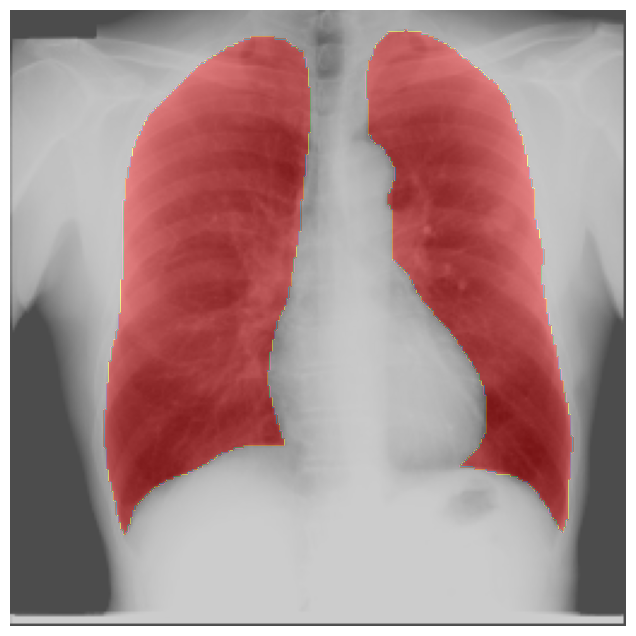

In [11]:
data_root='./datasets'
data_npz='lung_field_dataset.npz'
data_fn = os.path.join(data_root, "lung_field_dataset.npz")
force_download = False

if (not os.path.exists(data_fn)) or force_download:
  download_url("https://sid.erda.dk/share_redirect/gCTc6o3KAh", data_root, data_npz)
else:
  print('Using existing', data_fn)

# Load train/val/test data
x_train, y_train, x_val, y_val, x_test, y_test = load_npz_dataset(data_fn)
# Bring images into PyTorch format
x_train = np.moveaxis(x_train, 3, 1)
y_train = np.moveaxis(y_train, 3, 1)
x_val = np.moveaxis(x_val, 3, 1)
y_val = np.moveaxis(y_val, 3, 1)
x_test = np.moveaxis(x_test, 3, 1)
y_test = np.moveaxis(y_test, 3, 1)

print("x train:", x_train.shape)
print("y train:", y_train.shape)
print("x val: ", x_val.shape)
print("y val: ", y_val.shape)
print("x test:", x_test.shape)
print("y test:", y_test.shape)

# Init torch datasets
train_dataset = as_torch_dataset(x_train, y_train)
val_dataset = as_torch_dataset(x_val, y_val)
test_dataset = as_torch_dataset(x_test, y_test)

# Init dataloaders
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = torch.utils.data.DataLoader(val_dataset, batch_size=16, shuffle=False)
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=1, shuffle=False)

# Plot an example
fig, ax = plot_image_with_segmentation(*train_dataset[0])
plt.show()

### Init model and optimizer

In [12]:
# Init U-Net model
model = smp.Unet(encoder_name='efficientnet-b0',in_channels=1,classes=1)

model.to(device)

lr = 0.1 # learning rate
num_epochs = 3 # number of epochs

# Define optimizer
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

print(model)

Unet(
  (encoder): EfficientNetEncoder(
    (_conv_stem): Conv2dStaticSamePadding(
      1, 32, kernel_size=(3, 3), stride=(2, 2), bias=False
      (static_padding): ZeroPad2d((0, 1, 0, 1))
    )
    (_bn0): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
    (_blocks): ModuleList(
      (0): MBConvBlock(
        (_depthwise_conv): Conv2dStaticSamePadding(
          32, 32, kernel_size=(3, 3), stride=[1, 1], groups=32, bias=False
          (static_padding): ZeroPad2d((1, 1, 1, 1))
        )
        (_bn1): BatchNorm2d(32, eps=0.001, momentum=0.010000000000000009, affine=True, track_running_stats=True)
        (_se_reduce): Conv2dStaticSamePadding(
          32, 8, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_se_expand): Conv2dStaticSamePadding(
          8, 32, kernel_size=(1, 1), stride=(1, 1)
          (static_padding): Identity()
        )
        (_project_conv): Conv2dStaticSamePadding

### Continue training?

In [15]:
import wandb

In [16]:
# Specify integer, starting at 1
init_epoch = None
if init_epoch != None:
    load_model(model, f"epoch_{init_epoch}_model.ckpt", optimizer)

### Run training

In [17]:
# init wandb
run = wandb.init(project='ADL1')

# set config
config = wandb.config
config.learning_rate = lr
config.epochs = num_epochs

Failed to detect the name of this notebook, you can set it manually with the WANDB_NOTEBOOK_NAME environment variable to enable code saving.


wandb: Currently logged in as: ellenebdrup (ellenhxk874). Use `wandb login --relogin` to force relogin


In [18]:
# Define loss and metrics
loss = torch.nn.MSELoss(reduction="mean")
metrics = {"f1": torchmetrics.classification.F1Score(task='binary', num_classes=1, average="macro")}

# Run training
train_history, val_history = training_loop(
    model=model,
    loss=loss,
    optimizer=optimizer,
    train_loader=train_loader,
    val_loader=val_loader,
    init_epoch=init_epoch,
    n_epochs=num_epochs,
    metrics_dict=metrics,
    save_path="model.ckpt"
)

Epoch 1/3


   -- Batch 1/7 / Loss:  1.287463
   -- Batch 2/7 / Loss:  6.946421
   -- Batch 3/7 / Loss:  3.4783876
   -- Batch 4/7 / Loss:  4.220435
   -- Batch 5/7 / Loss:  1.1327412
   -- Batch 6/7 / Loss:  0.41833806
   -- Batch 7/7 / Loss:  0.8608469
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 2.6206622}
   Validation: {'f1': 0.4849940836429596, 'loss': 0.8809671401977539}
Train metrics: {'loss': 2.6206622}
   Saving to: epoch_1_model.ckpt
Epoch 2/3
   -- Batch 1/7 / Loss:  0.86063176
   -- Batch 2/7 / Loss:  0.5875783
   -- Batch 3/7 / Loss:  0.36359268
   -- Batch 4/7 / Loss:  0.29262573
   -- Batch 5/7 / Loss:  0.30230415
   -- Batch 6/7 / Loss:  0.31130165
   -- Batch 7/7 / Loss:  0.2925954
   Validation running...
   Mean epoch metrics:
   Training:   {'loss': 0.43008995}
   Validation: {'f1': 0.5105953812599182, 'loss': 0.2627105712890625}
Train metrics: {'loss': 0.43008995}
   Saving to: epoch_2_model.ckpt
Epoch 3/3
   -- Batch 1/7 / Loss:  0.2341315
   -- Ba

In [19]:
sweep_config = {
    'method': 'random',
    'metric': {"goal": "maximize", "name": "f1"},
    'parameters': {
        "learning_rate": {"values": [1, 0.01, 0.001]}, #high learning rates due to running time
        "batch_size": {"values": [16, 32, 64]},
    }}

sweep_id = wandb.sweep(sweep_config, project='ADL1')

Create sweep with ID: ktqhsvas
Sweep URL: https://wandb.ai/ellenhxk874/ADL1/sweeps/ktqhsvas


In [20]:
wandb.agent(sweep_id, function=training_loop, count=5)

wandb: WARNING Calling wandb.login() after wandb.init() has no effect.


<IPython.core.display.HTML object>
<IPython.core.display.HTML object>
<IPython.core.display.HTML object>


wandb: Agent Starting Run: slbk2ur5 with config:
wandb: 	batch_size: 64
wandb: 	learning_rate: 1
Exception in thread Thread-14 (_run_job):
Traceback (most recent call last):
  File "/Users/ellenebdrup/miniconda3/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 308, in _run_job
    self._function()
TypeError: training_loop() missing 6 required positional arguments: 'model', 'loss', 'optimizer', 'train_loader', 'val_loader', and 'n_epochs'

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/Users/ellenebdrup/miniconda3/lib/python3.10/threading.py", line 1016, in _bootstrap_inner
    self.run()
  File "/Users/ellenebdrup/miniconda3/lib/python3.10/threading.py", line 953, in run
    self._target(*self._args, **self._kwargs)
  File "/Users/ellenebdrup/miniconda3/lib/python3.10/site-packages/wandb/agents/pyagent.py", line 313, in _run_job
    wandb.finish(exit_code=1)
  File "/Users/ellenebdrup/miniconda3/lib/python3.10

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

### Plot training and validation histories

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

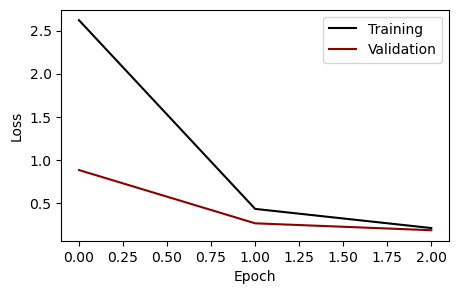

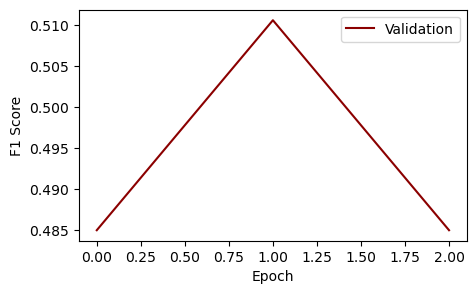

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [21]:
plot_histories(train_history['loss'], val_history['loss'], label="Loss")
plot_histories(train_history=None, val_history=val_history['f1'], label="F1 Score")
plt.show()

### Evaluate on single test-set image

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

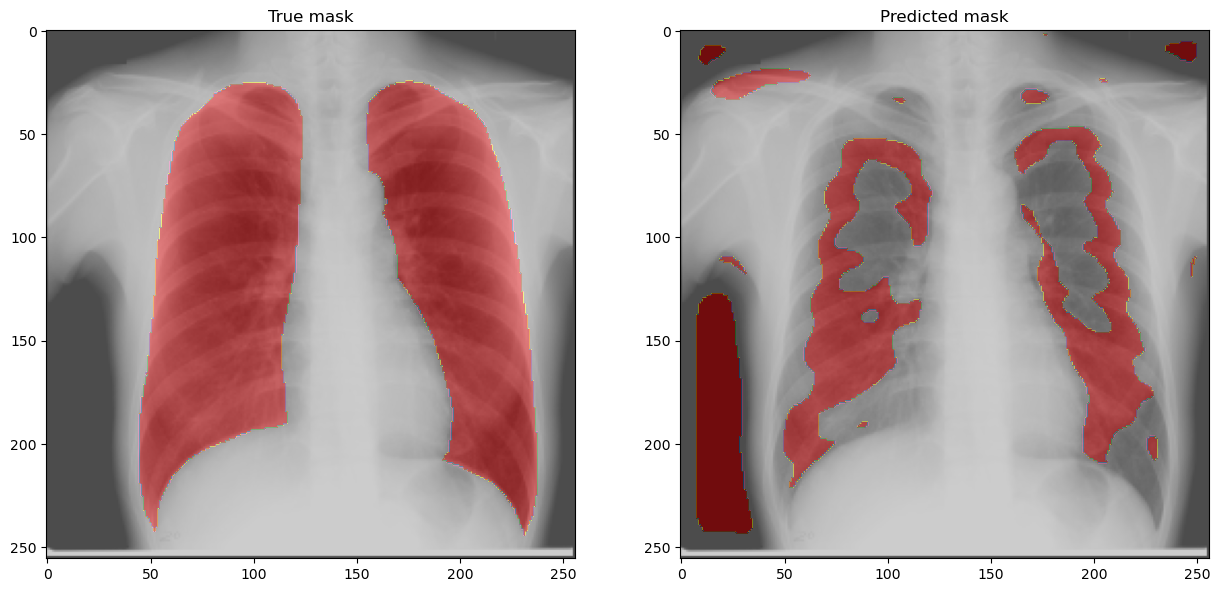

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [22]:
# Select a test image
x,y = test_dataset[0]
pred = evaluate_model_on_single_image(model, x)

# Plot the result
fig, (ax1, ax2) = plt.subplots(ncols=2, figsize=(15, 15))
ax1.set_title("True mask")
ax2.set_title("Predicted mask")
plot_image_with_segmentation(x, y, ax=ax1)
plot_image_with_segmentation(x, pred, ax=ax2)
plt.show()

### Evaluate on whole test-set

In [23]:
# OBS: Returns batch-wise metrics, but test_loader has batch_size = 1
f1_test_scores = evaluate_model(model, test_loader, metrics, reduction=False)["f1"]

print("Test cases:", len(f1_test_scores))
print("Mean F1:   ", np.mean(f1_test_scores))
print("STD  F1:   ", np.std(f1_test_scores))
print("Min. F1:   ", np.min(f1_test_scores))

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

Test cases: 123
Mean F1:    0.46369479221057114
STD  F1:    0.06439326675950638
Min. F1:    0.29554006457328796
Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

In [24]:
sum(p.numel() for p in model.parameters())

Error in callback <bound method _WandbInit._resume_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for pre_run_cell):


BrokenPipeError: [Errno 32] Broken pipe

6250893

Error in callback <bound method _WandbInit._pause_backend of <wandb.sdk.wandb_init._WandbInit object at 0x7f9112267970>> (for post_run_cell):


BrokenPipeError: [Errno 32] Broken pipe